### 3 Python中的PCA应用
为了能够比较清楚的解释应用方法，来，上python！

这里用鸢尾花的数据集，经典内味

https://zhuanlan.zhihu.com/p/116836637

In [1]:
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

iris = datasets.load_iris()
X = iris['data']
y = iris['target']

### 接下来会先用sklearn实现一次PCA，随后用numpy进行验证之前证明过程中推导的结果：

3.1 sklearn中的pca
初始化pca：

sklearn中的pca有两种初始化pca对象的方式——指定主成分数量初始化和指定保留方差量初始化，从数量开始：

结构为：

pca = PCA(n_components=xxx)
鸢尾花的例子中，可以：

In [2]:
print('Before pca: \n', X[:3,:])
pca_1 = PCA(n_components=2) # 指定主成分数量初始化
X_red_1 = pca_1.fit_transform(X) # fit并直接得到降维结果 

# 这里只展示前三行的结果以示对比
print('After pca: \n', X_red_1[:3, :],'\n')
# 查看各个特征值所占的百分比
print('explained_variance_ratio_: ', pca_1.explained_variance_ratio_)
# 线性变换规则
print('components_: ', pca_1.components_)

Before pca: 
 [[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]]
After pca: 
 [[-2.68412563  0.31939725]
 [-2.71414169 -0.17700123]
 [-2.88899057 -0.14494943]] 

explained_variance_ratio_:  [0.92461872 0.05306648]
components_:  [[ 0.36138659 -0.08452251  0.85667061  0.3582892 ]
 [ 0.65658877  0.73016143 -0.17337266 -0.07548102]]


### 会发现，在将为之前的数据是4维，但是pca处理过后就变成了两维。

这里还调用了一些其他的属性和方法：

fit_transform：能够得到降维后的数据因为pca是无监督的方法，可以这样操作，当然也可以拆开写；
explained_variance_ratio_：查看每个主成分保留的方差百分比；
explained_variance_ratio_.sum()：当前保留总方差百分比；
components_：主成分（特征值）对应的特征向量，这个很重要，能够查看数据降维过程中线性变换的规则。在解释性上，对应的，也能够了解每个原本字段在新特征构建过程中的权重（虽然没怎么用过）；
保留维度通常是为了更好的可视化，比如将带标签的高维数据映射到二维或者三维，能够很直接地看到原本数据的大体分布，然后根据这个来选择进一步的方法：

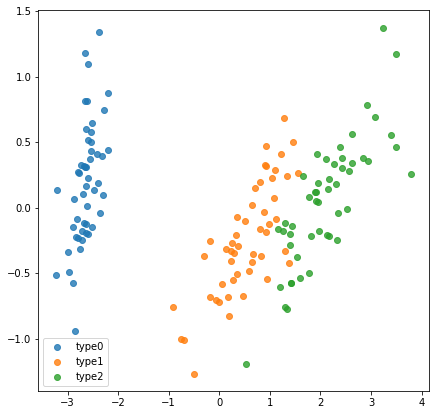

In [3]:
plt.figure(figsize=(7,7))    
for i in range(3):
    plt.scatter(x=X_red_1[np.where(y==i),:][0][:,0], y=X_red_1[np.where(y==i),:][0][:,1], alpha=0.8, label='type%s' % i)
plt.legend()
plt.show()

### 第二种，是指定保留方差量初始化。这一种方法可以在降维后查看保留的维度数量等等，比较懒人：

结构为：

### pca = PCA(0.98) # 即保留0.98的信息量（方差）
鸢尾花的例子中，可以：

In [4]:
print('Before pca: \n', X[:3,:])
pca_2 = PCA(0.98)
# 后续的操作都一样，仅仅在初始化上有区别
X_red_2 = pca_2.fit_transform(X)
print('After pca: \n', X_red_2[:3, :],'\n')
print('explained_variance_ratio_: ', pca_2.explained_variance_ratio_)
print('components_: ', pca_2.components_)

Before pca: 
 [[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]]
After pca: 
 [[-2.68412563  0.31939725 -0.02791483]
 [-2.71414169 -0.17700123 -0.21046427]
 [-2.88899057 -0.14494943  0.01790026]] 

explained_variance_ratio_:  [0.92461872 0.05306648 0.01710261]
components_:  [[ 0.36138659 -0.08452251  0.85667061  0.3582892 ]
 [ 0.65658877  0.73016143 -0.17337266 -0.07548102]
 [-0.58202985  0.59791083  0.07623608  0.54583143]]


### 方法同上，但是我们可以发现它在判定的时候将数据降到了3维当中。如果调用explained_variance_ratio_.sum()方法会发现现在有保留0.99+的方差。

那如何做出最开始的选择呢？

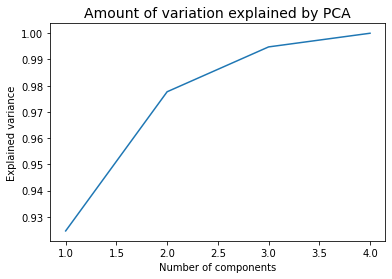

In [5]:
# Fitting PCA
pca = PCA()
pca.fit_transform(X)
# 对所有的保留情况进行累加（1个主成分，2个，...直到和原本数据维度相同
explained_var = np.cumsum(pca.explained_variance_ratio_)

# Plotting the amount of variation explained by PCA with different numbers of components
plt.plot(list(range(1, len(explained_var)+1)), explained_var)
plt.title('Amount of variation explained by PCA', fontsize = 14)
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.show()

可以看到保留2个或者3个都是很不错的选择；
那么以上基本就是sklearn中的pca了。

不过你可能还是会有问号。emmmmmm这不就和没讲一样吗？掉个包就完事儿，当中这么多映射规则，保留方差百分比什么的，和之前证明有什么关系吗？

那就到最后一部分，用numpy来验证我们证明中得到的细节——

### 3.2 Numpy验证PCA
根据推到步骤，首先我们应该将数据中心化，即每一列都减去当列的均值，需要注意的是，这里只会展示前3个观测（整个数据集有150条）的计算结果：

In [6]:
print(X[:3,:])
for i in range(X.shape[-1]):
    X[:,i]-=np.mean(X[:,i])
print(X[:3,:])

[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]]
[[-0.74333333  0.44266667 -2.358      -0.99933333]
 [-0.94333333 -0.05733333 -2.358      -0.99933333]
 [-1.14333333  0.14266667 -2.458      -0.99933333]]


### 接下来求X和其转置矩阵的特征值和对应的特征向量，在python中一行就可以搞定

In [7]:
eigenvalue, featurevector=np.linalg.eig(np.dot(X.T, X))
print('eigenvalue: \n', eigenvalue, '\n')
print('featurevector: \n', featurevector)

eigenvalue: 
 [630.0080142   36.15794144  11.65321551   3.55142885] 

featurevector: 
 [[ 0.36138659 -0.65658877 -0.58202985  0.31548719]
 [-0.08452251 -0.73016143  0.59791083 -0.3197231 ]
 [ 0.85667061  0.17337266  0.07623608 -0.47983899]
 [ 0.3582892   0.07548102  0.54583143  0.75365743]]


### 这个数字是不是感觉有点眼熟？

在特征向量的部分，几个数字和我们之前在pca.components_中看到的一样。

回想推导过程（假定原数据维度是Nxm）：

因为是单位向量，所以投影和方差一致；
我们用拉格朗日数乘法得到，在这种情况下特征值和方差数值相等；
根据需求，依次选择最高的k个特征值和对应的特征向量（m*j），即为线性变换规则；
将原数据矩阵矩阵（Nxm）中心化后，同选择的特征向量矩阵（mxj）相乘；
降维完毕；

### 回看上面的pca，在保留2维、3维的时候，所乘的矩阵确实由特征值自高往低排列，所对应的特征向量构成。

也就是说，这里印证了最大的几个特征值所对应的特征向量组合在一起，就构成了线性变换的规则，来进行降维映射。

那么接下来，就是选择最大的几个特征值，并得到对应的主成分，进行线性变换，验证一下：

In [8]:
# 保留两个维度进行降维
# 选择两个维度是为了方便可视化

# numpy 验证
dim_map = np.argsort(-eigenvalue)[:2]
vec = featurevector[:, dim_map]
result_np = np.dot(X, vec)

# pca 实现
pca = PCA(n_components=2)
result_pca = pca.fit_transform(X)
print('Head of result_pca:\n', result_pca[:3, :])
print('Head of result_np:\n', result_np[:3, :])
print('Feature vectors:\n', vec)
print('Components_:\n', pca.components_)

Head of result_pca:
 [[-2.68412563  0.31939725]
 [-2.71414169 -0.17700123]
 [-2.88899057 -0.14494943]]
Head of result_np:
 [[-2.68412563 -0.31939725]
 [-2.71414169  0.17700123]
 [-2.88899057  0.14494943]]
Feature vectors:
 [[ 0.36138659 -0.65658877]
 [-0.08452251 -0.73016143]
 [ 0.85667061  0.17337266]
 [ 0.3582892   0.07548102]]
Components_:
 [[ 0.36138659 -0.08452251  0.85667061  0.3582892 ]
 [ 0.65658877  0.73016143 -0.17337266 -0.07548102]]


### 那么验证成功了，只剩最后一个问题：保留特征百分比是什么？

### 将特征值转换为占比即可，验证一下：

In [9]:
eigenvalue/eigenvalue.sum(), pca.explained_variance_ratio_

(array([0.92461872, 0.05306648, 0.01710261, 0.00521218]),
 array([0.92461872, 0.05306648]))

### 验证成功

以上，就是我对PCA的理解

欢迎补充~